In [18]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from pprint import pprint

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pydot
import graphviz
import seaborn as sns;

from collections import Counter
from itertools import tee
from scipy import stats
from matplotlib.colors import ListedColormap

In [2]:
with open('trainspec.txt', 'r') as specfile:
    spec=specfile.read().replace('\n', '')
sentences = sent_tokenize(spec)

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [3]:
allTags = []
stopwords = [',','.']
dataDict = dict()
prevTag=''
currTag=''
Obs=[]
for sentence in sentences:
    wordTokens = word_tokenize(sentence)
    wordTokens = [w for w in wordTokens if w not in stopwords]
    posTags = pos_tag(wordTokens)
    for _curr_, _next_ in pairwise(posTags):
        if (_curr_[1],_next_[1]) in dataDict:
            dataDict[(_curr_[1],_next_[1])][0]+=1
        else:
            dataDict[(_curr_[1],_next_[1])]=[1]
        dataDict[(_curr_[1],_next_[1])].append((_curr_[0],_next_[0]))
        Obs.append((_curr_[1],_next_[1]))
    Obs.append((-1,-1))    
    tags = [(w,t) for (w,t) in posTags]
    
    allTags = allTags + tags

noOfObservations = len(dataDict) # we have the observations in the dict value index 0 for every key
print(noOfObservations)

# computing probabilities for each pair to decide the feature term selection criteria
tags = [t for (w,t) in allTags]
distinctTags = Counter(tags).keys()
distinctTagsCount = Counter(tags).values()
dTags = list(zip(distinctTags, distinctTagsCount))

# get tag pairs with NN, NNS, NNP or NNPS in it
pairs=[k for k,v in dataDict.items()]
nounBasedPairs = [(x,y) for (x,y) in pairs if x in ['NN','NNS','NNP','NNPS'] or y in ['NN','NNS','NNP','NNPS']]
print(nounBasedPairs)

tokens=[v[0] for k,v in dataDict.items()]
print(tokens)
totalNoOfToken = sum(tokens)

64
[('DT', 'NN'), ('NN', 'VBZ'), ('NN', 'POS'), ('POS', 'NNS'), ('NNS', 'NNS'), ('NNS', 'DT'), ('IN', 'NN'), ('NN', 'NNS'), ('NN', 'NN'), ('NN', 'DT'), ('NN', 'IN'), ('NN', 'MD'), ('JJ', 'NNS'), ('NNS', 'TO'), ('NNS', 'IN'), ('JJ', 'NN'), ('RB', 'NN'), ('VBZ', 'NNS'), ('NNS', 'VBG'), ('VBG', 'NNS'), ('IN', 'NNS'), ('NN', 'TO'), ('NNS', 'PRP'), ('NNS', 'VBP'), ('VBZ', 'NN'), ('IN', 'NNP'), ('NNP', 'DT'), ('DT', 'NNP'), ('NNP', 'VBZ'), ('NNP', 'NN'), ('NN', 'VBP'), ('POS', 'NN'), ('VB', 'NN'), ('VBN', 'NN'), ('NN', 'WDT'), ('DT', 'NNS'), ('VBP', 'NN')]
[14, 105, 55, 38, 2, 1, 1, 7, 4, 7, 13, 6, 3, 24, 11, 4, 1, 6, 2, 5, 11, 5, 5, 3, 11, 6, 2, 4, 3, 10, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1]


In [4]:
# calculate the probabilities for each tag pair
print(totalNoOfToken) #461

# update dictionary with probabilities
for v in dataDict.values():
    v[0]=v[0]/(totalNoOfToken)
probs = [vp[0] for vp in dataDict.values()]    
aKeys=[k for k,v in dataDict.items()]

417


In [5]:
threshold = max(np.median(probs),stats.mode(probs)[0])
print(threshold)

0.004796163069544364


In [6]:
# for filtering features
# model-1
validSeq = [k for k,val in dataDict.items() if val[0]>=threshold]
# model-2
validSeq = [k for k,val in dataDict.items() if k in nounBasedPairs]

# create the observation data
Obsv=[aKeys.index(_o) if _o in aKeys else len(aKeys) for _o in Obs]

In [7]:
# extracting probable feature terms
feature_start = 0
features = []
feature = []
for sentence in sentences:
    wordTokens = word_tokenize(sentence)
    wordTokens = [w for w in wordTokens if w not in stopwords]
    posTags = pos_tag(wordTokens)
    
    for _curr_, _next_ in pairwise(posTags):
        if (_curr_[1],_next_[1]) in validSeq:
            if feature_start == 0:
                feature_start = 1
                feature.append(_curr_[0])
                feature.append(_next_[0])
            else:
                feature.append(_next_[0])
        else:
            if feature_start == 1:
                feature_start = 0
                features.append(' '.join(feature))
                feature=[]
    if feature_start == 1:
        feature_start = 0
        features.append(' '.join(feature))
        feature=[]

# minimal clean up of features:
# - lower case feature names
# - removing duplicates

features = [f.lower() for f in features]
features = list(dict.fromkeys(features))
for f in features:
    subf = [_f for _f in features if _f != f]
    fsubset = [_f for _f in subf if f in _f]
    if len(fsubset)>0:
        features = subf

i = 0
for f in features:
    print("F"+str(i)+" - ",f.lower())
    i=i+1
# number of features
noOfStates = len(features)
print(noOfStates)

F0 -  the purchase 's payments details the supplier confirms
F1 -  the system asks
F2 -  for shipment details
F3 -  with credit cards
F4 -  a customer pays
F5 -  a credit card the system approves
F6 -  the payment by
F7 -  the credit card company
F8 -  the system completes
F9 -  an order the supplier can
F10 -  ordered products to
F11 -  the shipping documents via email
F12 -  the system finalizes
F13 -  a software order details the supplier ships
F14 -  ordered product via email
F15 -  different shipping options
F16 -  a customer buys
F17 -  small product the system supports
F18 -  air mail shipping
F19 -  the system displays
F20 -  registered customer buys
F21 -  the inventory
F22 -  with gift cards
F23 -  a gift card the system supports
F24 -  only land shipping
F25 -  the purchase status
F26 -  the system provides details on
F27 -  the product delivery status
F28 -  the product return page
F29 -  the customer returns
F30 -  the product page
F31 -  a supplier enters
F32 -  new produ

In [8]:
# HMM implementation. Preparing row stochatic inputs
O = np.array([Obsv])

T = len(O[0]) # of observations

M = len(np.unique(O))
A = np.empty((noOfStates, noOfStates))  #Rows are present state
B = np.empty((noOfStates, M)) #likelihood of intial state , +1 for spaces
N = np.shape(B)[0]

# Initial probabilities
for i in range(0,noOfStates):
    A[i]=np.random.dirichlet(np.ones(noOfStates),size=1)
    B[i]=np.random.dirichlet(np.ones(M),size=1)

pi = np.random.rand(N) # likelihood of intial state
pi = pi/pi.sum()

print("O=",O)
print("A=",A)
print("B=",B)
print("pi=",pi)
print(N)
print(M)
print(T)

O= [[ 0  1  2  3  1  4  5  6  7  1  2  3  1 64  1  2  8  9 10 64  1  2 11 12
   9 10 64  0  1  2  8  0  1 13 14  1  2 15 16  1 17 18 19  1 13 13 64 20
   1  2 11 19  1 14  1 21 22 23 24 25 26 27  1 64  1  2  3  1 10 28  9 64
  20  1  2  3  1 13 10  7  1  2  3 24 29 17  9 64  1  2  3  1 10 64  1  2
  30 29 10 64 31  0  1  2  3 32 33 29 14  1  2 15 33 29 13 64  1  2  3 24
  25 64 20 24 29  2  3  1 14  1  2  3  1 64  1  2 11 12  9 10 64  0  1  2
   8  0  1 13 14  1  2 15 34 13 64  1 21 22 23  1 13 64  1  2 35 28  0  1
  13 13 64  1  2  3  1 13 13 64  0  1  2  3  1 14  1  2  3  1 64  1  2  3
   1 13 64 20  1  2 30 25  7  1  2  3  1 64  1  2 35 36 37 28 38 64 20  1
   2  3  1 14  1  2  3  1 13 39 27 24 29 64 20  1  2 30 25 40 41  3 24 25
  26 27  1 64  1  2  3  1 64 20  1  2  3 24 25 42 43  1 21 22 23  1 64  1
   2  3  1 13 64  1  2  3 24 29 64  0  1 10  7  1 14  1  2  3  1 64 20  1
   2  3  1 13 10  7  1  2  3 24 29 17  9 64  1  2  3  1 13 13 64 20  1  2
  44 10  7  1  2  3  1 64  1  2  3 

In [9]:
# Reused the implementation from https://github.com/rbnsnsd2/hidden_markov_model (uses Mark Stamp's pseudo code)
def init_matrices(O, N):
   
    T = len(O[0])
    M = len(np.unique(O))
    A = np.random.rand(N,N)
    A = A/A.sum(axis=1)[:,None]
    B = np.random.rand(N,M)
    B = B/B.sum(axis=1)[:,None]
    pi = np.random.rand(N)
    pi = pi/pi.sum()
    c = np.zeros((T))
    alpha = np.zeros((T,N))
    beta = np.zeros((T,N))
    gamma = np.zeros((T,N))
    digam = np.zeros((T,N,N))
    return A, B, pi, alpha, beta, gamma, digam, M, T, c

maxIters = 100
iters = 0
oldLogProb = -10**100

c = np.zeros((T))
alpha = np.zeros((T,N))
beta = np.zeros((T,N))
gamma = np.zeros((T,N))
digam = np.zeros((T,N,N))

def apass(A,B,pi,alpha,N,T,c):
    c[0] = 0
    for i in range(N):  
        alpha[0,i] = pi[i]*B[i,O[0,0]]
        c[0] = c[0] + alpha[0,i]
        
    c[0] = 1/c[0]
    for i in range(N):
        alpha[0,i] = c[0]*alpha[0,i]
    
    for t in range(1,T): 
        c[t] = 0
        
        for i in range(N): 
            alpha[t,i] = 0
            for j in range(N): 
                alpha[t,i] = alpha[t,i] + alpha[t-1,j]*A[j,i]
            alpha[t,i] = alpha[t,i]*B[i,O[0,t]]
            c[t] = c[t] + alpha[t,i]
            
        c[t] = 1/c[t] #Scale alpha[t,i]
        for i in range(N):
            alpha[t,i] = c[t]*alpha[t,i]
    return alpha, c

def bpass(A,B,pi,beta,N,T,c):
    for i in range(N):
        beta[T-1,i] = c[T-1]
        
    for t in range(T-2,-1,-1):
        for i in range(N):
            beta[t,i] = 0
            for j in range(N):
                beta[t,i] = beta[t,i] + A[i,j]*B[j,O[0,t+1]]*beta[t+1,j]            
            beta[t,i] = c[t]*beta[t,i]
            
    return beta, c

def digamma(A,B,pi,alpha,beta,gamma,digam,N,T):
    for t in range(T-1):
        for i in range(N):
            gamma[t,i] = 0
            for j in range(N):
                digam[t,i,j] = alpha[t,i]*A[i,j]*B[j,O[0,t+1]]*beta[t+1,j]
                gamma[t,i] = gamma[t,i] + digam[t,i,j]
    for i in range(N):
        gamma[T-1,i] = alpha[T-1,i]
    
    return gamma, digam

def re_est(A,B,pi,gamma,digam):
    for i in range(N):
        pi[i] = gamma[0,i]
        
    for i in range(N):
        for j in range(N):
            numer = 0
            denom = 0
            for t in range(T-1):
                numer = numer + digam[t,i,j]
                denom = denom + gamma[t,i]
            A[i,j] = numer/denom
            
    for i in range(N):
        for j in range(M):
            numer = 0
            denom = 0
            for t in range(T):
                if O[0,t] == j: numer = numer + gamma[t,i]
                denom = denom + gamma[t,i]
            B[i,j] = numer/denom
    return A, B, pi

def logprob(c):
    return -np.sum(np.log(c))      
         
def markov(O,N):
    iters = 0
    logProb = 0
    delta = 1
    A, B, pi, alpha, beta, gamma, digam, M, T, c = init_matrices(O,N)
    while iters <= maxIters and logProb >= oldLogProb and delta >= 0.000001:
        alpha, c = apass(A,B,pi,alpha,N,T,c)
        beta, c = bpass(A,B,pi,beta,N,T,c)
        gamma, digam = digamma(A,B,pi,alpha,beta,gamma,digam,N,T)
        A, B, pi = re_est(A,B,pi,gamma,digam)
        delta1 = logProb
        logProb = logprob(c)
        delta = np.absolute(delta1 - logProb)
        iters = iters + 1
    print("Interations: ", iters)
    return A,B,pi,alpha,beta,gamma,digam

def fitObservations(o,maxIter,N, M, a, b, p):
    T = len(o[0])    
    
    for t in range(0,T):
        if o[0,t] > M:
            return 'Invalid data'
      
    oldLogProb=-np.log(0)
    currIter=0    
    
    A = a
    B = b
    c = np.zeros((T))
    pi = p
    
    alpha = np.zeros((T,N))
    beta = np.zeros((T,N))
    gamma = np.zeros((T,N))
    digam = np.zeros((T,N,N))
    
    for i in range(0,maxIters):
        currIter = i
        alpha, c = apass(A,B,pi,alpha,N,T,c)
        beta, c = bpass(A,B,pi,beta,N,T,c)
        gamma, digam = digamma(A,B,pi,alpha,beta,gamma,digam,N,T)
        
        A, B, pi = re_est(A,B,pi,gamma,digam)
        logProb = logprob(c)
        if logProb <= oldLogProb:
            break
        oldLogProb = logProb;
    return currIter, A, B, pi;

def p_obs_lambda(alpha):
    return np.sum(alpha[T-1,:])

def p_state(gamma):
    return np.argmax(gamma,axis=1)

In [10]:
#A, B, pi, alpha, beta, gamma, digam = markov(O,N)
itr,A,B,pi = fitObservations(O,5,N, M, A, B, pi)
print("A = {}\nB = {}".format(A,B))
print("pi = {}".format(pi))

C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in log


A = [[0.00950147 0.02598282 0.00940017 ... 0.01835193 0.01047832 0.00846778]
 [0.01205526 0.00246956 0.00031428 ... 0.00085705 0.00513453 0.01552943]
 [0.00163962 0.0431368  0.00515679 ... 0.01592979 0.03866244 0.00523629]
 ...
 [0.00361631 0.02664977 0.02055353 ... 0.01382082 0.0297443  0.00270454]
 [0.00056378 0.05854308 0.00234576 ... 0.00035906 0.00932415 0.00631269]
 [0.00829058 0.00185371 0.003989   ... 0.00264859 0.01740119 0.06868638]]
B = [[3.54066918e-02 3.36160421e-01 5.70245790e-02 ... 1.32609321e-04
  2.67519105e-04 1.56153691e-01]
 [4.73211516e-02 4.95249262e-01 1.85628611e-02 ... 9.34756446e-04
  1.01209823e-03 2.73601614e-02]
 [2.42253420e-02 1.98164497e-01 1.00231949e-01 ... 9.15868043e-03
  8.48777573e-03 3.06229990e-02]
 ...
 [1.45101291e-03 2.98436252e-01 4.65363392e-02 ... 2.85138868e-03
  2.14330220e-03 1.41713458e-01]
 [4.33454951e-02 3.24710943e-01 2.08411745e-02 ... 1.99363740e-03
  3.17377346e-04 9.63589443e-02]
 [5.43983564e-02 1.72380383e-01 9.69344689e-03 .

In [76]:
print(np.max(pi))
print(np.sort(pi))

0.0929155391214
[4.96072866e-07 2.90110660e-05 3.77330549e-05 1.18126022e-04
 1.34664944e-04 1.64972288e-04 2.54642217e-04 3.34568884e-04
 3.59400218e-04 3.82777597e-04 4.62209073e-04 4.78463894e-04
 5.74587420e-04 6.52146713e-04 7.17012824e-04 1.06782616e-03
 1.21584042e-03 1.24521939e-03 1.31456017e-03 1.94906419e-03
 2.19748031e-03 2.54020686e-03 2.75864871e-03 2.83797553e-03
 3.73652838e-03 3.98246436e-03 4.35278632e-03 5.61976566e-03
 6.93756169e-03 6.98270794e-03 8.12503201e-03 8.46933765e-03
 8.53547796e-03 8.81731849e-03 9.36274318e-03 9.66982068e-03
 1.02133673e-02 1.03087866e-02 1.05840159e-02 1.07184367e-02
 1.08955548e-02 1.10275014e-02 1.15403435e-02 1.16240043e-02
 1.26506949e-02 1.29792556e-02 1.32461108e-02 1.33278052e-02
 1.43733503e-02 1.45225891e-02 1.59328166e-02 1.59415823e-02
 1.75349760e-02 1.98953976e-02 2.00118531e-02 2.09901775e-02
 2.27995478e-02 2.53707565e-02 2.80508592e-02 3.10374161e-02
 3.68453862e-02 3.80946812e-02 5.06169445e-02 5.32916552e-02
 7.34742

In [68]:
states = ["F"+str(i) for i in range(0,noOfStates)]

finalTransitionMatrix = pd.DataFrame(columns=states, index=states)
for i in range(0,noOfStates):
    finalTransitionMatrix.loc[states[i]] = A[i]
    
finalTransitionMatrix.to_excel("output.xlsx")

In [69]:
# Create graph and visualize
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)

# edges represent transition probabilities
for i in range(0,noOfStates):
    for j in range(0,noOfStates):
        tmp_origin, tmp_destination = "F"+str(i), "F"+str(j)
        G.add_edge(tmp_origin, tmp_destination, weight=A[i][j], label=A[i][j])
pprint(G.edges(data=True))    

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
#nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'fm_markov.dot')

OutMultiEdgeDataView([('F0', 'F0', {'weight': 0.009501471451549103, 'label': 0.009501471451549103}), ('F0', 'F1', {'weight': 0.025982817303582408, 'label': 0.025982817303582408}), ('F0', 'F2', {'weight': 0.009400165725123198, 'label': 0.009400165725123198}), ('F0', 'F3', {'weight': 0.004249552462190461, 'label': 0.004249552462190461}), ('F0', 'F4', {'weight': 0.0003885022980838352, 'label': 0.0003885022980838352}), ('F0', 'F5', {'weight': 0.016073069147599314, 'label': 0.016073069147599314}), ('F0', 'F6', {'weight': 0.002219321505503135, 'label': 0.002219321505503135}), ('F0', 'F7', {'weight': 0.008118634012454084, 'label': 0.008118634012454084}), ('F0', 'F8', {'weight': 0.0030970934180232015, 'label': 0.0030970934180232015}), ('F0', 'F9', {'weight': 0.03648825562493909, 'label': 0.03648825562493909}), ('F0', 'F10', {'weight': 0.044996902168904215, 'label': 0.044996902168904215}), ('F0', 'F11', {'weight': 0.01597990729700489, 'label': 0.01597990729700489}), ('F0', 'F12', {'weight': 0.0

In [70]:
dataProcessing = A.flatten()
mu = np.mean(dataProcessing)
sigma = np.std(dataProcessing)

# Confidence 95% Interval Construction
LeftInter = -(1.96*sigma)+(mu)
RightInter = (1.96*sigma)+(mu)

print(LeftInter)
print(RightInter)

# Confidence for 90% 1.645
LeftInter1 = -(1.645*sigma)+(mu)
RightInter1 = (1.645*sigma)+(mu)

print(LeftInter1)
print(RightInter1)

-0.015055742178278195
0.04446750688416055
-0.010272623950046512
0.03968438865592887


In [72]:
normalizedArr = []
narr = []
for x in dataProcessing:
    val=(x-mu)/(sigma)
    narr.append(val)
    if val>=LeftInter1 and val<=RightInter1:
        normalizedArr.append(0)
    elif val<LeftInter1:
        normalizedArr.append(-1)
    else:
        normalizedArr.append(1)
        
A_norm = np.asarray(normalizedArr, dtype=np.float32)
A_norm = A_norm.reshape(68,68)
for i in range(0,noOfStates):
    finalTransitionMatrix.loc[states[i]] = A_norm[i]
    
n_arr = np.asarray(narr, dtype=np.float32)
n_arr = n_arr.reshape(68,68)
for i in range(0,noOfStates):
    finalTransitionMatrix.loc[states[i]] = n_arr[i]
        
finalTransitionMatrix.to_excel("normalized_output.xlsx")

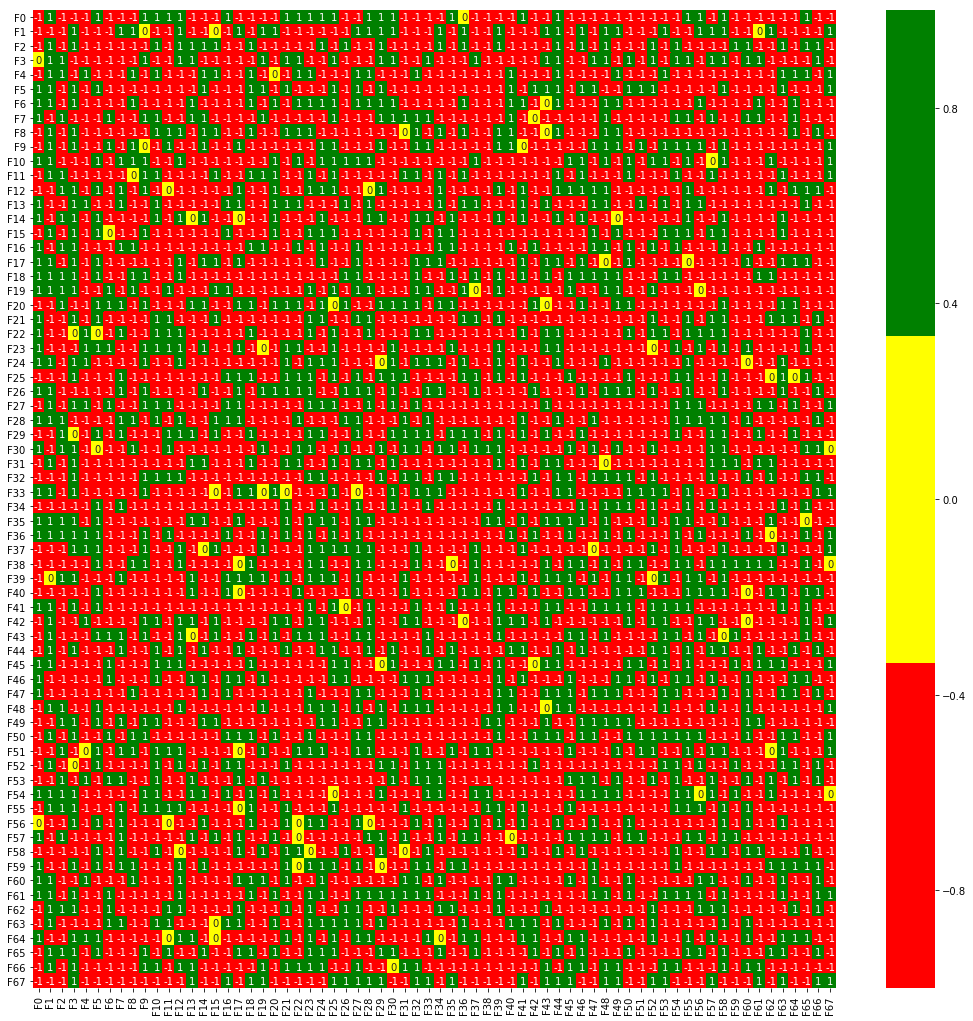

In [84]:
data=A_norm[0:68,0:68]
df = pd.DataFrame(data, columns=states[0:68],index=states[0:68])
plt.figure(figsize=(18, 18))
sns.heatmap(df, cmap=ListedColormap(['red', 'yellow', 'green']), annot=True)

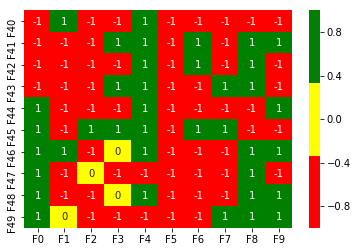

In [85]:
data=A_norm[0:10,40:50]
df = pd.DataFrame(data, columns=states[0:10],index=states[40:50])
sns.heatmap(df, cmap=ListedColormap(['red', 'yellow', 'green']), annot=True)